# 정상성, 비정상성

* 1. 정상 프로세스(Stationary Process)
 * 시간에 관계없이 평균과 분산이 일정한 시계열 데이터<br>
 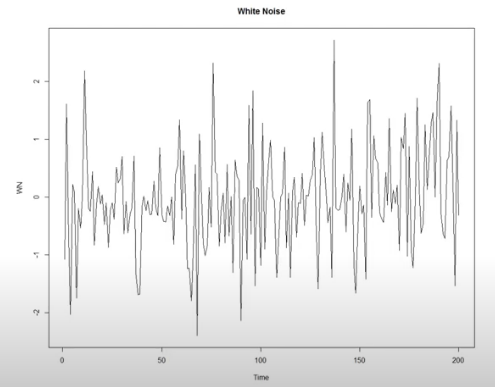

* 정상성 확인 by Autocorrelation Function의 패턴<br>
 * 눈으로 정상성을 판단하기 어려운 경우가 있음
 * ACF(Auto Correlation Function) : lag는 시차를 의미
 * PACF(Partial Auto Correlation Function)<br>
 => 특정한 패턴이 없다면 정상성을 띈다고 이야기할 수 있음
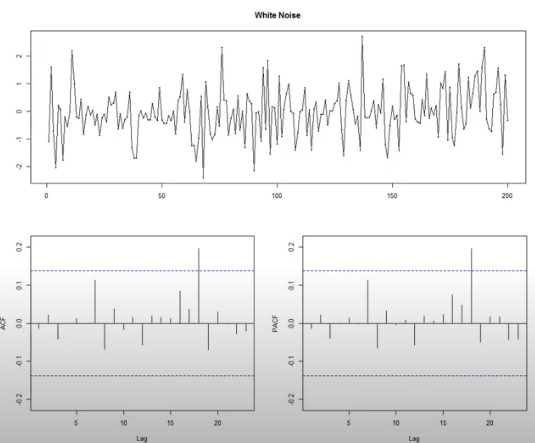

* 2. 비정상 프로세스(Nonstationary Process)
 * 시간에 따라 평균과 분산이 일정하지 않은 데이터<br>
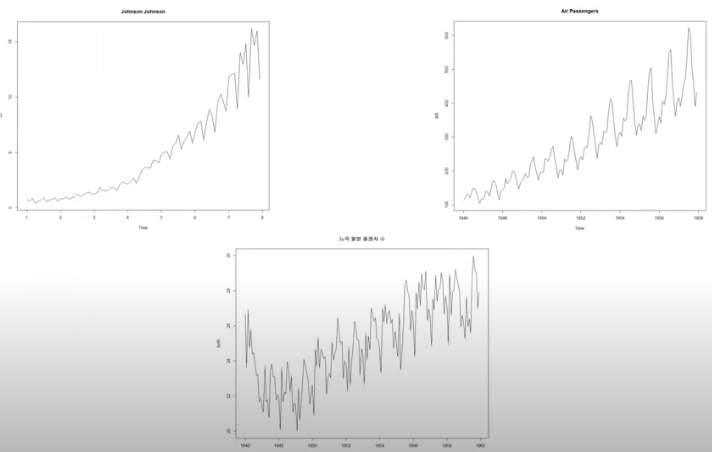

* 비정상성 확인 by Autocorrelation Function의 패턴
 * ACF, PCAF가 특정한 패턴을 보이고 있음<br>
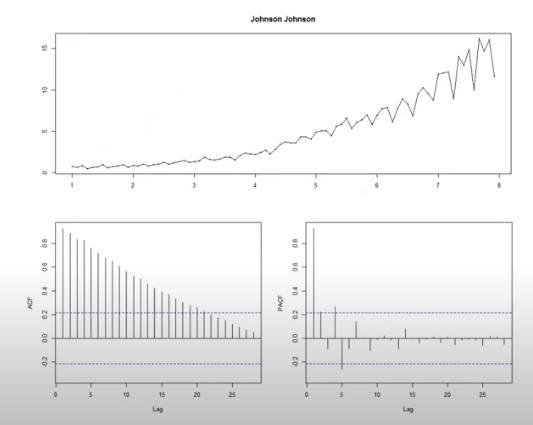

# AR(AutoRegressive) 모델<br>
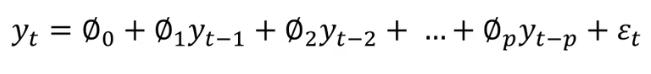<br>
* yt가 관심있는 값, x값은 y값의 lag를 사용 => 현재 p 시점 전의 데이터까지 사용
* y값을 사용하는 것이기 때문에 독립성이 위반되어 파이를 구할 때 최소제곱법을 구할 수 없음

# MA(MovingAverage) 모델<br>
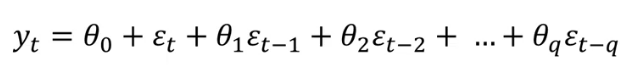<br>
* t 시점에서의 값을 에러인 엡실론 값을 이용해서 표현

# ARMA(AutoRegressive and MovingAverage) 모델<br>
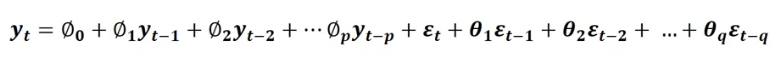<br>
* AR 모델과 MA 모델을 합친 모델

# ARIMA(AutoRegressive Intergrated MovingAverage) 모델<br>
* AR, MA, ARMA 등 모델을 사용하기 위해서는 정상성을 만족해야 함
* 따라서, 정상성을 확보하기 위해 differencing(차분)을 함
* differencing을 했다는 것을 여기서 integrated라고 표현함 => 따라서 이 I는 차분을 몇 번을 했는지를 의미
* (p, d, q)
* p : AR 모델의 parameter의 개수
* q : MA 모델의 parameter의 개수
* d : 차분 횟수

# 차분 (Differencing)<br>
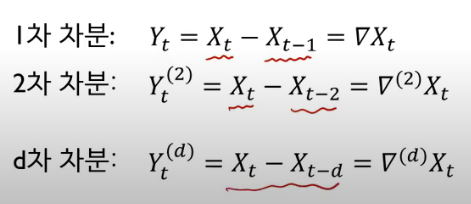<br>
=> 즉, 차분은 현 시점 데이터에서 d 시점 이전의 데이터를 뺀 것<br>
=> 복잡한 시계열 데이터를 가질수록 차분 횟수가 늘어남<br>
=> 또한, 대부분의 데이터는 2차 차분을 하면 정상성을 가지게 됨

___

* 모듈 임포트

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import datetime
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
import seaborn as sns

* sqlite DB에서 데이터 불러오기

In [2]:
con = sqlite3.connect(r"C:\Users\gram\OneDrive\바탕 화면\stock_project\stock.db")
df = pd.read_sql("SELECT * FROM '039490'", con, index_col=None)
df.rename(columns={'index':'date'}, inplace=True)
df = df.set_index('date')
df

,open,high,low,close,volume
date,,,,,
20220516,86900,87600,85700,85900,55383
20220513,84000,87400,83500,85800,86525
20220512,84700,85300,82700,83200,104007
20220511,87500,87500,85500,85800,108071
20220510,87500,88600,87000,88000,100350
...,...,...,...,...,...
20040429,5117,5436,5025,5101,109911
20040428,5071,5452,4995,5444,182604
20040427,5452,5482,5033,5063,299489


* 데이터 정렬

In [3]:
df.sort_index(ascending=True, inplace=True)
df

,open,high,low,close,volume
date,,,,,
20040423,6076,6799,5353,5353,1415109
20040426,5436,5741,5261,5398,343283
20040427,5452,5482,5033,5063,299489
20040428,5071,5452,4995,5444,182604
20040429,5117,5436,5025,5101,109911
...,...,...,...,...,...
20220510,87500,88600,87000,88000,100350
20220511,87500,87500,85500,85800,108071
20220512,84700,85300,82700,83200,104007


* 행 인덱스를 datetime 객체로 변환

In [4]:
df.index = pd.DatetimeIndex(df.index)
df.index

DatetimeIndex(['2004-04-23', '2004-04-26', '2004-04-27', '2004-04-28',
               '2004-04-29', '2004-04-30', '2004-05-03', '2004-05-04',
               '2004-05-06', '2004-05-07',
               ...
               '2022-05-02', '2022-05-03', '2022-05-04', '2022-05-06',
               '2022-05-09', '2022-05-10', '2022-05-11', '2022-05-12',
               '2022-05-13', '2022-05-16'],
              dtype='datetime64[ns]', name='date', length=4470, freq=None)

* 종가 변수 가져온 후 종가 plot 확인

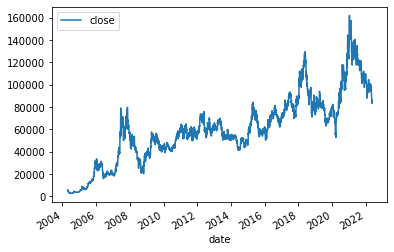

In [5]:
stock_data = df[['close']]
fig = stock_data.plot()

=> 평균과 분산이 일정하지 않아 정상성을 만족하지 않으므로 차분이 필요하겠음<br>
=> 계절성이나 주기성이 크게 관찰되지 않음

* train, test 데이터 분리

In [6]:
from sklearn.model_selection import train_test_split
stock_data_train, stock_data_test = train_test_split(stock_data, test_size = 0.05, shuffle = False)

* ACF, PACF를 통한 정상성 확인
 * squeeze() 함수는 배열을 1차원으로 축소

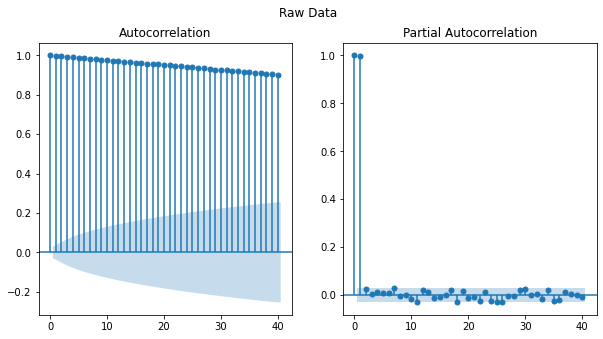

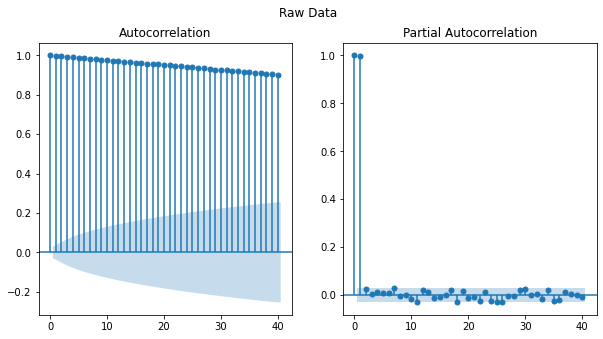

In [7]:
import statsmodels.api as sm

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(stock_data_train.values.squeeze(), lags = 40, ax = ax[0])
sm.graphics.tsa.plot_pacf(stock_data_train.values.squeeze(), lags = 40, ax = ax[1])

=> ACF가 점진적으로 감소하기 때문에 비정상성이므로 차분을 진행

* 차분 횟수 추정

In [16]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(stock_data_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(stock_data_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


* 차분

In [8]:
diff_stock_data_train = stock_data_train.copy()
diff_stock_data_train = diff_stock_data_train['close'].diff()
diff_stock_data_train = diff_stock_data_train.dropna()
print('#### Raw Data ####')
print(stock_data_train)
print('#### Differenced Data ####')
print(diff_stock_data_train)

#### Raw Data ####
             close
date              
2004-04-23    5353
2004-04-26    5398
2004-04-27    5063
2004-04-28    5444
2004-04-29    5101
...            ...
2021-06-11  119000
2021-06-14  117500
2021-06-15  121000
2021-06-16  120000
2021-06-17  121000

[4246 rows x 1 columns]
#### Differenced Data ####
date
2004-04-26      45.0
2004-04-27    -335.0
2004-04-28     381.0
2004-04-29    -343.0
2004-04-30    -152.0
               ...  
2021-06-11     500.0
2021-06-14   -1500.0
2021-06-15    3500.0
2021-06-16   -1000.0
2021-06-17    1000.0
Name: close, Length: 4245, dtype: float64


* 차분 후 plot

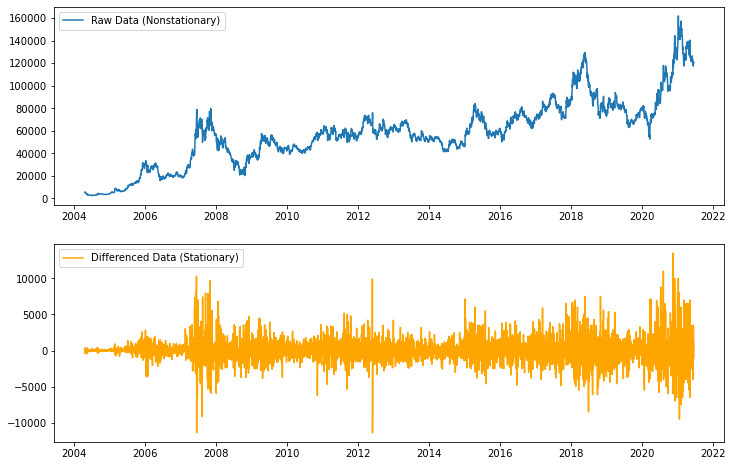

In [9]:
plt.figure(figsize = (12, 8))
plt.subplot(211)
plt.plot(stock_data_train['close'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_stock_data_train, 'orange')
plt.legend(['Differenced Data (Stationary)'])
plt.show()

* 차분 후 ACF, PACF를 통한 정상성 확인

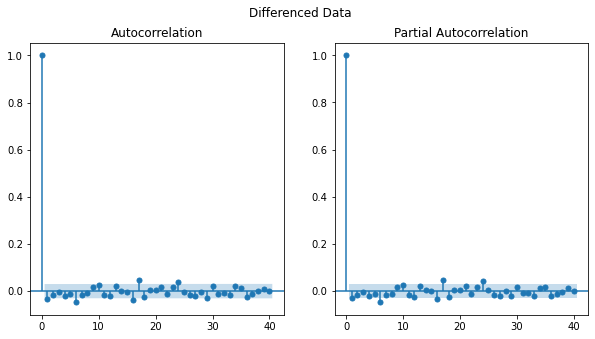

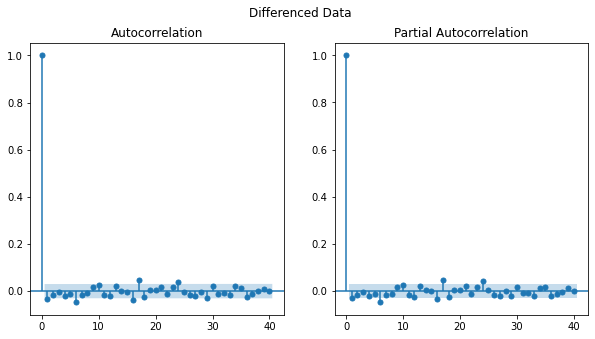

In [10]:
import statsmodels.api as sm

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_stock_data_train.values.squeeze(), lags = 40, ax = ax[0])
sm.graphics.tsa.plot_pacf(diff_stock_data_train.values.squeeze(), lags = 40, ax = ax[1])

* auto_arima를 통한 파라미터 탐색

In [11]:
import pmdarima as pm

auto_arima_model = pm.auto_arima(stock_data_train, start_p = 1, start_q = 1,
                              max_p = 3, max_q = 3, seasonal = False,
                              d = 1,
                              trace = True, # 결과 지속적 출력
                              error_action = 'ignore',
                              suppress_warnings = True,
                              stepwise = False) # 

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=75467.647, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=75465.100, Time=1.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=75466.015, Time=1.01 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=75467.910, Time=1.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=75465.243, Time=0.71 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=75465.728, Time=4.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=75467.640, Time=2.64 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=75469.180, Time=2.94 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=75466.097, Time=0.70 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=75467.897, Time=1.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=75462.712, Time=6.74 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=19.94 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=75468.033, Time=0.71 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=75470.021, Time=1.00 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=75464.579, Time=11.32 sec

In [12]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4246
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -37725.356
Date:                Wed, 25 May 2022   AIC                          75462.712
Time:                        15:30:21   BIC                          75500.833
Sample:                             0   HQIC                         75476.184
                               - 4246                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     30.4221     16.975      1.792      0.073      -2.848      63.692
ar.L1         -0.2518      0.094     -2.674      0.008      -0.436      -0.067
ar.L2          0.6466      0.100      6.439      0.000       0.450       0.843
ma.L1          0.2232      0.090      2.486      0.013       0.047       0.399
ma.L2         -0.6905      0.096     -7.224      0.000      -0.878      -0.503
sigma2      3.073e+06   3.35e+04     91.787      0.000    3.01e+06    3.14e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              7478.64
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               2.32   Skew:                             0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* 예측

In [13]:
prediction = auto_arima_model.predict(len(stock_data_test), return_conf_int = True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:, 0]
predicted_lb = prediction[1][:, 1]
predict_index = list(stock_data_test.index)
predict_index[0]

Timestamp('2021-06-18 00:00:00')

* 예측 plot

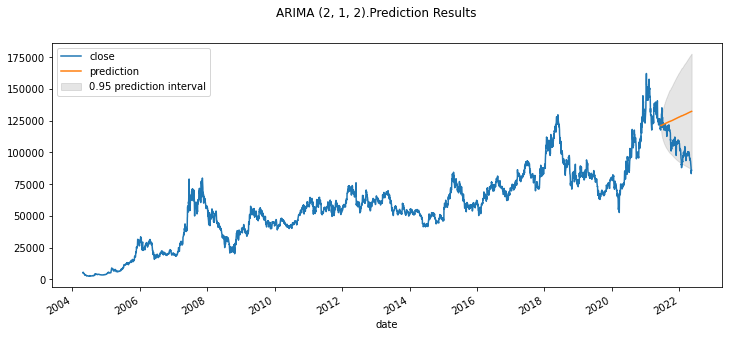

In [28]:
fig, ax = plt.subplots(figsize = (12, 5))
stock_data.plot(ax = ax)
ax.plot(predict_index, predicted_value, label = 'prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 prediction interval')
ax.legend(loc = 'upper left')
plt.suptitle(f'ARIMA {auto_arima_model.order}.Prediction Results')
plt.show()